In [1]:
import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as sf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, FMClassifier
from pyspark.ml import Pipeline
from pyspark.sql import types as st

from replay.models import RandomRec

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import evaluate_synthetic
from sim4rec.response import ParametricResponseFunction, BernoulliResponse, NoiseResponse

from replay.models import ThompsonSampling

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .config('spark.driver.maxResultSize', '256g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

24/04/22 23:35:56 WARN Utils: Your hostname, ecs-syudosaev-big resolves to a loopback address: 127.0.1.1; using 10.11.12.124 instead (on interface eth0)
24/04/22 23:35:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/22 23:35:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/22 23:35:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
import pyspark.sql.types as st

USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

items_df_train = spark.read.csv('train/items.csv', header=True, schema=ITEM_SCHEMA)
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")

for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

In [3]:
users_df_val = spark.read.csv('val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv('val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

log_df_val = log_df_val.cache()

log_df_val.count()

5000065

In [4]:
users_df_test = spark.read.csv('test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv('test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv('test/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_test = users_df_test.withColumnRenamed("user_idx", "user_id")
items_df_test = items_df_test.withColumnRenamed("item_idx", "item_id")
log_df_test = log_df_test.withColumnRenamed("user_idx", "user_id")
log_df_test = log_df_test.withColumnRenamed("item_idx", "item_id")

log_df_test = log_df_test.join(users_df_test, log_df_test['user_id'] == users_df_test['user_id'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_id'] == items_df_test['item_id'], 'leftsemi')

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

log_df_test = log_df_test.cache()

log_df_test.count()

5000066

In [5]:
train_df = log_df_val.join(items_df_train, 'item_id', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

test_df = log_df_test.join(items_df_val, 'item_id', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

item_svd = spark.read.csv('item_svd.csv', header=True, inferSchema=True)
user_svd = spark.read.csv('user_svd.csv', header=True, inferSchema=True)

train_df = train_df.join(item_svd, on='item_id', how='left')
train_df = train_df.join(user_svd, on='user_id', how='left')
train_df = train_df.fillna(0)

test_df = test_df.join(item_svd, on='item_id', how='left')
test_df = test_df.join(user_svd, on='user_id', how='left')
test_df = test_df.fillna(0)

In [6]:
# print('train statistics')
# print(train_df.count())
# print(train_df.select('user_id').distinct().count())
# print(train_df.select('item_id').distinct().count())
# print(train_df.count() / (train_df.select('user_id').distinct().count() * train_df.select('item_id').distinct().count()))
# print()

# print('test statistics')
# print(test_df.count())
# print(test_df.select('user_id').distinct().count())
# print(test_df.select('item_id').distinct().count())
# print(test_df.count() / (test_df.select('user_id').distinct().count() * test_df.select('item_id').distinct().count()))

In [7]:
# train statistics                                                                       
# 4999437                                                                         
# 30213                                                                          
# 10295                                                                            
# 0.016073146324042473

# test statistics                                                                          
# 4998881                                                                         
# 37597                                                                        
# 26418
# 0.0050329158620026635

In [8]:
va = VectorAssembler(
    inputCols=items_df_train.columns[2:] + item_svd.columns[1:] + user_svd.columns[1:],
    outputCol='features'
)

fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

vee = VectorElementExtractor(inputCol='proba', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = Pipeline(stages=[va, lr, vee, mc, br])
pipeline_rf = Pipeline(stages=[va, rf, vee, mc, br])
pipeline_fm = Pipeline(stages=[va, fm, vee, mc, br])

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='scores')
br = BernoulliResponse(inputCol='scores', outputCol='response')
pipeline_rand = Pipeline(stages=[noise_resp, br])

lr_model = pipeline_lr.fit(train_df)
# rf_model = pipeline_rf.fit(train_df)
# fm_model = pipeline_fm.fit(train_df)
# rand_model = pipeline_rand.fit(train_df)

24/04/22 23:38:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/22 23:38:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


24/04/22 23:38:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/04/22 23:38:27 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [9]:
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# def get_baseline(test_df):
#     test_df = test_df.select('item_rating_avg', 'relevance').toPandas()
#     test_df['baseline'] = (test_df['item_rating_avg']-test_df['item_rating_avg'].min())/(test_df['item_rating_avg'].max()-test_df['item_rating_avg'].min())
#     test_df['baseline_bin'] = np.where(test_df['baseline'] > 0.5, 1, 0) 
#     print(f"ROC AUC (baseline): {roc_auc_score(test_df.relevance, test_df.baseline)}")
#     print(f"Precision (baseline): {precision_score(test_df.relevance, test_df.baseline_bin)}")
#     print(f"Recall (baseline): {recall_score(test_df.relevance, test_df.baseline_bin)}")
#     print(f"Accuracy (baseline): {accuracy_score(test_df.relevance, test_df.baseline_bin)}")
#     print(f"F1 (baseline): {f1_score(test_df.relevance, test_df.baseline_bin)}")
#     print()

# def assess_models(model, test_df):
#     pred_df = model.transform(test_df).select("relevance", "scores").toPandas()
#     pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)
#     print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
#     print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
#     print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
#     print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")
#     print(f"F1 (classificator): {f1_score(pred_df.relevance, pred_df.response_bin)}")
#     print()

# get_baseline(test_df)
# assess_models(lr_model, test_df)
# assess_models(rf_model, test_df)
# assess_models(fm_model, test_df)
# assess_models(rand_model, test_df)

In [10]:
# ROC AUC (baseline): 0.6422977846004425
# Precision (baseline): 0.8358102086034046
# Recall (baseline): 0.7951526338166802
# Accuracy (baseline): 0.702376591881263
# F1 (baseline): 0.8149746535680876

                                                                                
# ROC AUC (classificator): 0.6769131456007109
# Precision (classificator): 0.832028723575394
# Recall (classificator): 0.9840246054565328
# Accuracy (classificator): 0.8230732037830066
# F1 (classificator): 0.9016659625091726

                                                                                
# ROC AUC (classificator): 0.6702304186089241
# Precision (classificator): 0.8243268843567191
# Recall (classificator): 1.0
# Accuracy (classificator): 0.8243268843567191
# F1 (classificator): 0.9037052421089407

                                                                                
# ROC AUC (classificator): 0.6671387531188318
# Precision (classificator): 0.8322885098991416
# Recall (classificator): 0.9790606574786105
# Accuracy (classificator): 0.8201101406494774
# F1 (classificator): 0.8997281699070774

                                                                                
# ROC AUC (classificator): 0.5006585630991773
# Precision (classificator): 0.8244574752349586
# Recall (classificator): 0.49972577554558534
# Accuracy (classificator): 0.49990127790599537
# F1 (classificator): 0.62227437323843

In [11]:
item_generator = RealDataGenerator(label='items_real', seed=42)
user_generator = RealDataGenerator(label='users_real', seed=42)

users_df = train_df.select(*user_svd.columns).drop('item_id').distinct()
items_df = train_df.drop(*user_svd.columns, 'user_id', 'relevance').distinct().cache()

# передадим популяции пользователей и айтемов
item_generator.fit(items_df)
user_generator.fit(users_df)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(items_df.count())
user_generator.generate(users_df.count())

24/04/22 23:39:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/22 23:39:20 WARN CacheManager: Asked to cache already cached data.


DataFrame[user_id: int, uembed_0: double, uembed_1: double, uembed_2: double, uembed_3: double, uembed_4: double, uembed_5: double, uembed_6: double, uembed_7: double, uembed_8: double, uembed_9: double, uembed_10: double, uembed_11: double, uembed_12: double, uembed_13: double, uembed_14: double, uembed_15: double, uembed_16: double, uembed_17: double, uembed_18: double, uembed_19: double, uembed_20: double, uembed_21: double, uembed_22: double, uembed_23: double, uembed_24: double, uembed_25: double, uembed_26: double, uembed_27: double, uembed_28: double, uembed_29: double, uembed_30: double, uembed_31: double, uembed_32: double, uembed_33: double, uembed_34: double, uembed_35: double, uembed_36: double, uembed_37: double, uembed_38: double, uembed_39: double, uembed_40: double, uembed_41: double, uembed_42: double, uembed_43: double, uembed_44: double, uembed_45: double, uembed_46: double, uembed_47: double, uembed_48: double, uembed_49: double, uembed_50: double, uembed_51: double

In [12]:
from replay.data import FeatureSchema, FeatureInfo, FeatureType, FeatureHint, Dataset

feature_schema = FeatureSchema(
    [
        FeatureInfo(
            column="user_id",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.QUERY_ID,
        ),
        FeatureInfo(
            column="item_id",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        ),
        FeatureInfo(
            column="relevance",
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.RATING,
        ),
    ]
)

In [13]:
dummy_log = Dataset(feature_schema=feature_schema, interactions=pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]})))

ucb_lr = ThompsonSampling()
ucb_lr.fit(dummy_log)

ucb_rf = ThompsonSampling()
ucb_rf.fit(dummy_log)

ucb_fm = ThompsonSampling()
ucb_fm.fit(dummy_log)

ucb_rand = ThompsonSampling()
ucb_rand.fit(dummy_log)

24/04/22 23:39:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/04/22 23:39:49 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


24/04/22 23:39:50 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:50 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:50 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


24/04/22 23:39:53 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:53 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


24/04/22 23:39:54 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:54 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:55 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:55 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:55 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:55 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:55 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
24/04/22 23:39:56 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


In [14]:
def calc_metric(response_df):
    return (response_df
            .groupBy("user_id").agg(sf.sum("response").alias("num_positive"))
            .select(sf.mean("num_positive")).collect()[0][0]
           )

In [ ]:
from sim4rec.modules import Simulator

def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(0.1).dropna().cache()
    log = simul.get_log(user_df=users)
    log = pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]})) if log is None else log
    log = Dataset(feature_schema=feature_schema, interactions=log)

    recs = model.predict(
        log,
        k=5,
        queries=users,
        items=items_df,
        filter_seen_items=True,
    ).cache()

    resp = simul.sample_responses(
        recs_df=recs, 
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    simul.update_log(resp, iteration=iteration)

    metrics.append(calc_metric(resp))

    model._clear_cache()
    ucb_train_log = simul.log.cache()
    model.fit(Dataset(feature_schema=feature_schema, interactions=ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('response', 'relevance')))

    log.unpersist()
    users.unpersist()
    recs.unpersist()
    resp.unpersist()
    ucb_train_log.unpersist()

sim_lr = Simulator(user_generator, item_generator, f'checkpoints/lr', None, 'user_id', 'item_id', spark)
sim_rf = Simulator(user_generator, item_generator, f'checkpoints/rf', None, 'user_id', 'item_id', spark)
sim_fm = Simulator(user_generator, item_generator, f'checkpoints/fm', None, 'user_id', 'item_id', spark)
sim_rand = Simulator(user_generator, item_generator, f'checkpoints/rand', None, 'user_id', 'item_id', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(30):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ucb_lr, lr_model, i, lr_metrics)
    # do_a_cycle(sim_rf, ucb_rf, rf_model, i, rf_metrics)
    # do_a_cycle(sim_fm, ucb_fm, fm_model, i, fm_metrics)
    # do_a_cycle(sim_rand, ucb_rand, rand_model, i, rnd_metrics)
    
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

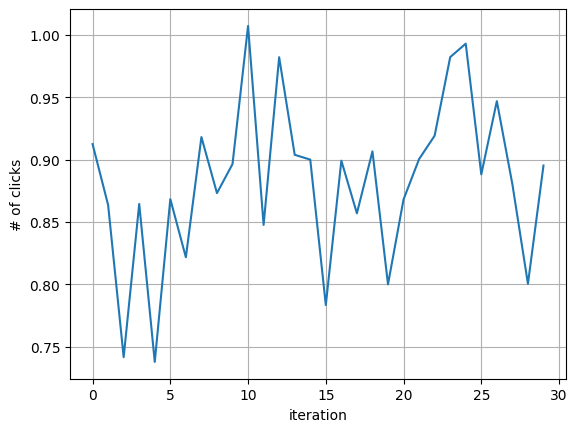

In [17]:
plt.plot(lr_metrics)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('# of clicks')
plt.show()